# Runnning sweep over distributions

In [11]:
import sys
sys.path.append('/Users/sstk4353/packages/WIPL_python_analysis/Complex_Multi_Body/')

#import WIPL_python_analysis.ComplexMultiBody.ComplexMultiBody as cmb
from ComplexMultiBody import ComplexMultiBody as cmb
from simulation_script import generate_distribution_df, run_simulation
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed


np.random.seed(42)  # For reproducibility

sys.path.append('./')

Import generate dataset run simulation script 11 times, save datasets in dictionary

## Define plotting function

In [54]:
def plot_result(output_object, output_attribute, title_str, unit, plot_kwargs=None):

    fig, ax = plt.subplots(figsize=(10, 6))

    for run_id, output_object in output_object.items():
        output = getattr(output_object, output_attribute)

        p1, p2, size1, size2 = run_id.split('_')

        mixing_ratio = f'{p1}_{p2}'
        angles = np.arange(0,360, 2)

        ax.plot(angles, output, label=f'{int(float(p1)*100)}% 9mm {int(float(p2)*100)}% 17mm', linestyle = '--', **plot_kwargs)

    ax.set_xlabel('Azimuth (degrees)')
    ax.set_ylabel(title_str + f' ({unit})')
    ax.set_title(f'Variation {title_str} with size mixing ratio')
    ax.legend()
    plt.grid()



## Default simulation parameters

In [6]:
radar_params = {
    'range_gate_separation': 600,  # meters
    'radar_beam_width': 1,  # degrees
    'range_of_observation': 150000,  # meters
    'beam_angle': 0.5,  # degrees
}

biological_params = {
    'density': 10e-5,  # scatterers per cubic meter
    'sizes': [9,17],  # size in mm
    'size_distribution': [0.7,0.3],  # not used in this example
    'mean_heading': 0,  # degrees
    'heading_spread': 20,  # degrees
    'mean_pitch': 11,  # degrees
    'pitch_spread': 10,  # degrees
}

In [7]:
scatterer_dataset = '/Users/sstk4353/packages/WIPL_python_analysis/Complex_Multi_Body/bioscatterer_database_v0.001.nc'
frequency = 5.6  # GHz

## Run simulations

In [ ]:
simulation_outputs = {}
run_id_list = []

for counter in range(0,11):
    prob_1 = counter / 10
    prob_2 = 1 - prob_1
    biological_params['size_distribution'] = [prob_1, prob_2]
    
    run_id = f"{prob_1}_{prob_2}_9_17"
    run_id_list.append(run_id)

    df = generate_distribution_df(radar_params, biological_params, run_id, save =False)
    CMB = run_simulation(df, xr.open_dataset(scatterer_dataset), frequency=frequency)
    simulation_outputs[run_id] = CMB





Radar beam radius: 1308.996938995747 m
Radar volume size: 3229820487.531231 m^3
Estimated number of scatterers: 322982
Spacing between scatterers: 21.544346900318832 m
Radar beam radius: 1308.996938995747 m
Radar volume size: 3229820487.531231 m^3
Estimated number of scatterers: 322982
Spacing between scatterers: 21.544346900318832 m
Radar beam radius: 1308.996938995747 m
Radar volume size: 3229820487.531231 m^3
Estimated number of scatterers: 322982
Spacing between scatterers: 21.544346900318832 m
Radar beam radius: 1308.996938995747 m
Radar volume size: 3229820487.531231 m^3
Estimated number of scatterers: 322982
Spacing between scatterers: 21.544346900318832 m
Radar beam radius: 1308.996938995747 m
Radar volume size: 3229820487.531231 m^3
Estimated number of scatterers: 322982
Spacing between scatterers: 21.544346900318832 m
Radar beam radius: 1308.996938995747 m
Radar volume size: 3229820487.531231 m^3
Estimated number of scatterers: 322982
Spacing between scatterers: 21.5443469003

## Trying to run simulations in parallel

I should write this as a script so I can parallelise it properly

In [12]:
def single_run(counter, radar_params, biological_params, scatterer_dataset, frequency):
    # Local copy of biological_params to avoid race conditions
    bio_params = biological_params.copy()
    prob_1 = counter / 10
    prob_2 = 1 - prob_1
    bio_params['size_distribution'] = [prob_1, prob_2]
    
    run_id = f"{prob_1}_{prob_2}_9_17"

    # Generate distribution dataframe
    df = generate_distribution_df(radar_params, bio_params, run_id, save=False)
    
    # Run simulation
    CMB = run_simulation(df, xr.open_dataset(scatterer_dataset), frequency=frequency)
    
    return run_id, CMB

def run_parallel_simulations(radar_params, biological_params, scatterer_dataset, frequency):
    simulation_outputs = {}
    run_id_list = []

    # Use ProcessPoolExecutor for CPU-bound work
    with ThreadPoolExecutor() as executor:
        futures = {
            executor.submit(single_run, counter, radar_params, biological_params, scatterer_dataset, frequency): counter
            for counter in range(0, 11)
        }

        for future in as_completed(futures):
            run_id, CMB = future.result()
            simulation_outputs[run_id] = CMB
            run_id_list.append(run_id)

    return simulation_outputs, run_id_list

# Example usage
simulation_outputs, run_id_list = run_parallel_simulations(
    radar_params, biological_params, scatterer_dataset, frequency
)

Radar beam radius: 1308.996938995747 m
Radar volume size: 3229820487.531231 m^3
Estimated number of scatterers: 322982
Spacing between scatterers: 21.544346900318832 m
Radar beam radius: 1308.996938995747 m
Radar volume size: 3229820487.531231 m^3
Estimated number of scatterers: 322982
Spacing between scatterers: 21.544346900318832 m
Radar beam radius: 1308.996938995747 m
Radar volume size: 3229820487.531231 m^3
Estimated number of scatterers: 322982
Spacing between scatterers: 21.544346900318832 m
Radar beam radius: 1308.996938995747 m
Radar volume size: 3229820487.531231 m^3
Estimated number of scatterers: 322982
Spacing between scatterers: 21.544346900318832 m
Radar beam radius: 1308.996938995747 m
Radar volume size: 3229820487.531231 m^3
Estimated number of scatterers: 322982
Spacing between scatterers: 21.544346900318832 m
Radar beam radius: 1308.996938995747 m
Radar volume size: 3229820487.531231 m^3
Estimated number of scatterers: 322982
Spacing between scatterers: 21.5443469003

In [52]:
sorted_simulations_outputs = {run_id: simulation_outputs[run_id] for run_id in sorted(run_id_list, reverse=True)}

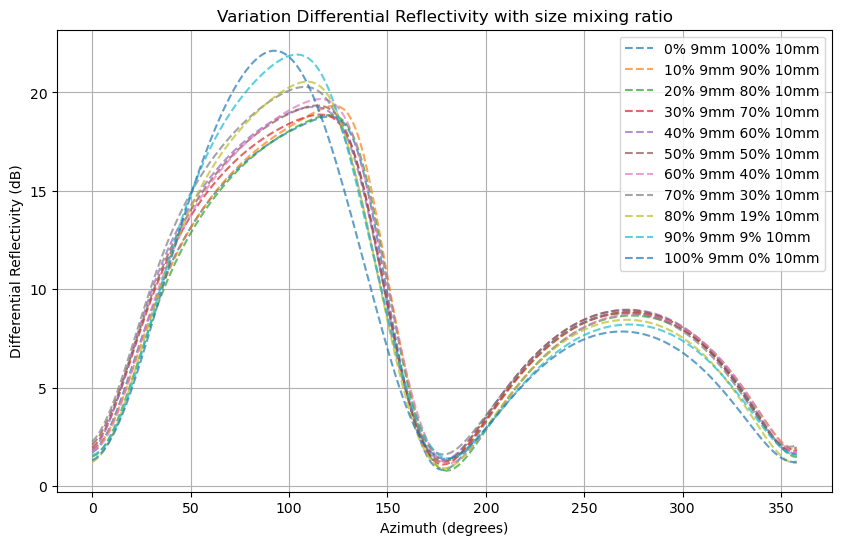

In [49]:
plot_result(sorted_simulations_outputs, 'differential_reflectivity', 'Differential Reflectivity', 'dB', plot_kwargs={'alpha': 0.7})

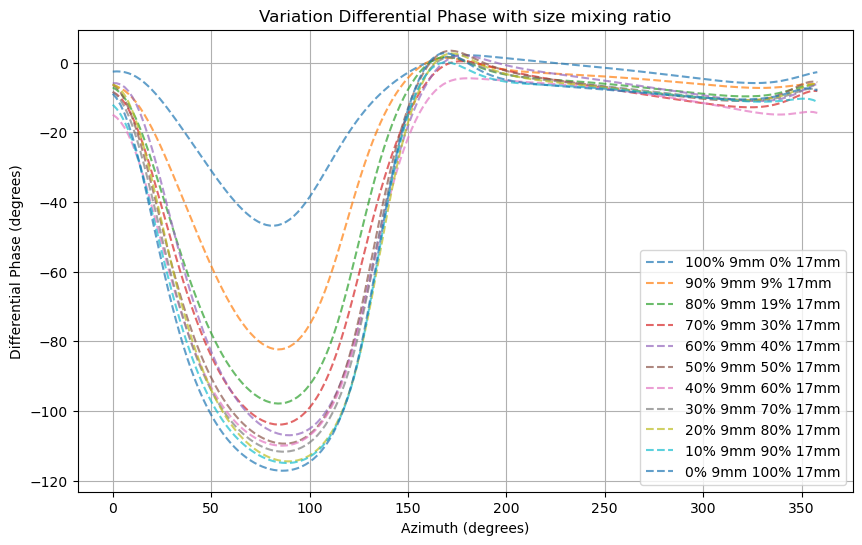

In [55]:
plot_result(sorted_simulations_outputs, 'differential_phase', 'Differential Phase',  'degrees', plot_kwargs={'alpha': 0.7})